# LSTM Time Series Forecasting for NVIDIA Stock Prices

## Data Extraction

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime

import yfinance as yf

In [58]:
# Define the stock list
stocks_list = ['NVDA']

# Define the date range
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

# Download stock data
for stock in stocks_list:
    globals()[stock] = yf.download(stock, start, end)

# Reset the index and rename columns
NVDA.reset_index(inplace=True)
NVDA.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Check for NaN values in each column
print("\nNumber of NaN values in each column:")
print(NVDA.isna().sum())

[*********************100%***********************]  1 of 1 completed


Number of NaN values in each column:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [59]:
# Create a new data frame with only the 'Close' column
nvidia_data = NVDA[['Close']]

# Drop rows where 'Close' is NaN
nvidia_data = nvidia_data.dropna()

# Print the resulting DataFrame after dropping NaN values
print("\nDataFrame after dropping NaN values:")
print(nvidia_data.head())

# Check if the resulting DataFrame is empty
if nvidia_data.empty:
    raise ValueError("All values in the 'Close' column are NaN. Please check your data source.")

# Convert the DataFrame to a NumPy array
data = nvidia_data.values

# Print the resulting data array
print("\nResulting data array:")
print(data)


DataFrame after dropping NaN values:
    Close
0  13.834
1  13.497
2  13.543
3  13.219
4  13.421

Resulting data array:
[[ 13.83399963]
 [ 13.49699974]
 [ 13.54300022]
 [ 13.21899986]
 [ 13.42099953]
 [ 14.15600014]
 [ 14.30099964]
 [ 14.60200024]
 [ 13.77600002]
 [ 15.75      ]
 [ 16.32699966]
 [ 16.29500008]
 [ 16.66600037]
 [ 15.90999985]
 [ 15.67700005]
 [ 15.4090004 ]
 [ 15.31700039]
 [ 16.03800011]
 [ 16.5189991 ]
 [ 16.27000046]
 [ 15.82699966]
 [ 15.63899994]
 [ 16.92300034]
 [ 17.13500023]
 [ 16.87599945]
 [ 16.61000061]
 [ 15.98700047]
 [ 16.12000084]
 [ 17.16900063]
 [ 17.00099945]
 [ 17.53499985]
 [ 18.0720005 ]
 [ 17.67399979]
 [ 16.95199966]
 [ 16.57099915]
 [ 16.25399971]
 [ 16.08499908]
 [ 16.50099945]
 [ 15.33899975]
 [ 15.20600033]
 [ 14.12100029]
 [ 14.03600025]
 [ 14.60299969]
 [ 14.61400032]
 [ 14.31499958]
 [ 14.7489996 ]
 [ 14.26500034]
 [ 14.85900021]
 [ 15.62800026]
 [ 15.9090004 ]
 [ 16.00099945]
 [ 16.51099968]
 [ 16.89900017]
 [ 17.70199966]
 [ 17.37700081]

## Data Pre-Processing

In [60]:
# Standardize the data (standardization is less sensitive to outliers compared to normalization)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [61]:
# Split the scaled data into training and testing sets
training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train, y_train datasets
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i,0])

# Convert the x_train and y_train to numppy array and reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(342, 60, 1)

## Long Short-Term Memory (LSTM)

In [62]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=25))
model.add(Dense(units=1))
model.summary()

/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,226 (149.32 KB)

 Trainable params: 38,226 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Compile and train the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0400
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0123
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0074
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0079
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0071
Epoch 9/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0064
Epoch 10/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0078
Epoch 11/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0053
Epoch 12/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0051
Epoch 13/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0036
Epoch 14/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0051
Epoch 15/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s

In [64]:
# Prepare test data and make predictions
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = data[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i -60:i, 0])

In [65]:
# Convert the data to a numpy array and reshape the data
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [66]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [67]:
# Evaluate model performance using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 7.416251118411867


/var/folders/8h/4l9_c_8x4pq675w1qcpf84hw0000gn/T/ipykernel_3813/250737844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


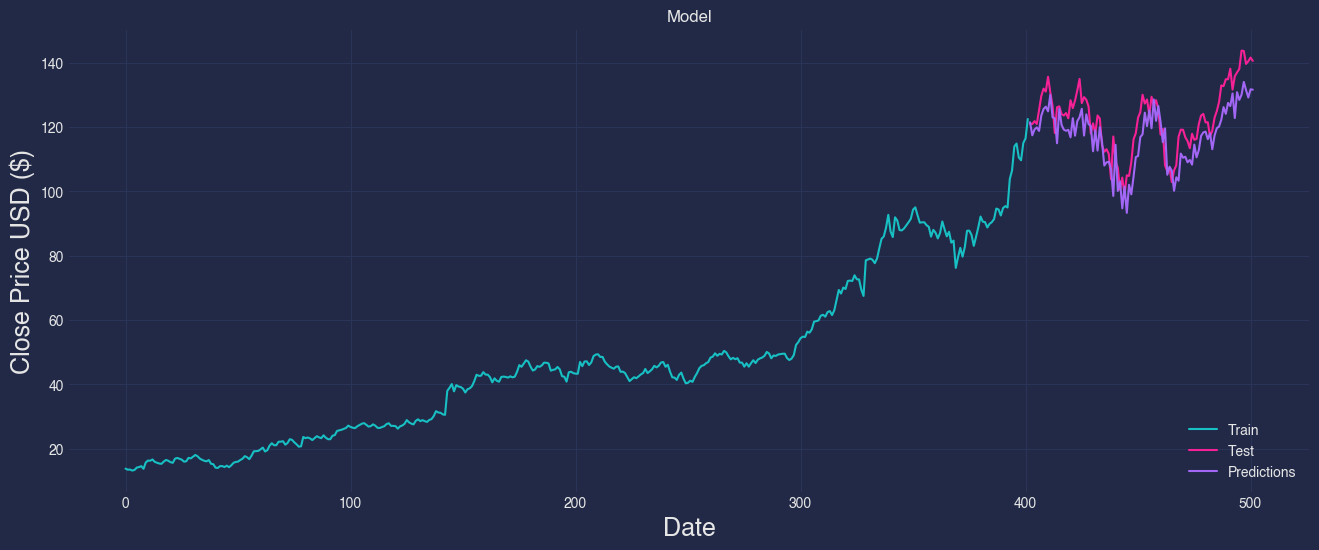

In [68]:
# Plot the predicted stock prices against actual prices
dataset = nvidia_data.filter(['Close'])
train = dataset[:training_data_len]
test = dataset[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [69]:
# Show the test and predicted price
test

,Close,Predictions
402,120.998001,121.434944
403,120.888000,117.392464
404,121.790001,119.213562
405,120.910004,119.842651
406,125.199997,118.751419
...,...,...
497,143.589996,133.978104
498,139.559998,131.428696
499,140.410004,129.136139
500,141.539993,131.677689


Text(0, 0.5, 'Actual Values')

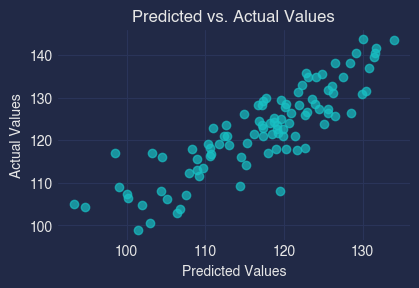

In [70]:
# Evaluate how well the LSTM model performs.
# If the predictions perfectly match the actual values, the points should align along a straight line with a slope of 1.

actual_values = y_test
predicted_values = predictions

plt.figure(figsize=(10, 6))

# Scatter plot of predicted vs. actual values
plt.subplot(2, 2, 1)
plt.scatter(predicted_values, actual_values, alpha=0.7)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

Text(0, 0.5, 'Residuals')

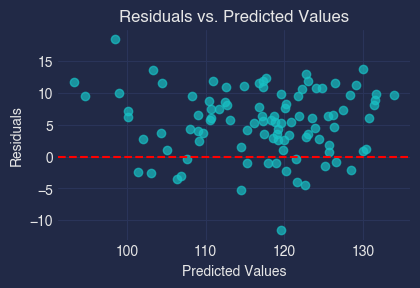

In [71]:
# Evaluate the relationship between observed and predicted values.
# Residuals distributed randomly around y = 0 indicate a well-captured data structure, whereas patterns or trends indicate model inadequacy.

# Calculate residuals
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))

# Residuals vs. Predicted Values
plt.subplot(2, 2, 2)
plt.scatter(predicted_values, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Frequency')

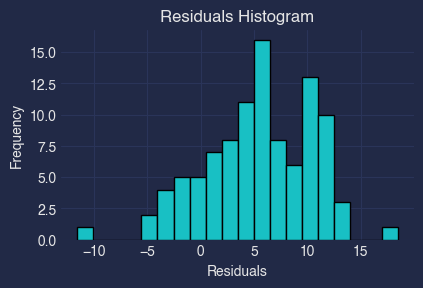

In [72]:
plt.figure(figsize=(10, 6))

# Residuals Histogram
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')